## Introduction

Current deep neural architectures for processing sensor data are mainly designed for data coming from a fixed set of sensors, with a fixed sampling rate. Changing the dimensions of the input data causes considerable accuracy loss, unnecessary computations, or application failures. To address this problem, we introduce a **dimension-adaptive pooling (DAP)** layer that makes deep architectures robust to temporal changes in sampling rate and in sensor availability. DAP operates on convolutional filter maps of variable dimensions and produces an input of fixed dimensions suitable for feedforward and recurrent layers. Building on this architectural improvement, we propose a **dimension-adaptive training (DAT)** procedure to generalize over the entire space of feasible data dimensions at the inference time. DAT comprises the random selection of dimensions during the forward passes and optimization with accumulated gradients of several backward passes. We then can combine DAP and DAT to transform existing non-adaptive deep architectures into a **Dimension-Adaptive Neural Architecture (DANA)** without altering other architectural aspects. Our solution does not need up-sampling or imputation, thus reduces unnecessary computations at inference time. Experimental results on public datasets show that DANA prevents losses in classification accuracy of the state-of-the-art deep architectures, under dynamic sensor availability and varying sampling rates.

Paper: https://arxiv.org/abs/2008.02397
Code: https://github.com/mmalekzadeh/dana

### Import Libraries 

Firs things first :)

Current version uses TensorFlow version 2.3.0 

In [1]:
!pip install tensorflow==2.3.0

In [2]:
import numpy as np
import time
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.0


### Import Dataset

Here we use UCI-HAR dataset: "Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors"

More info: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones 

In [3]:
## In this dataset Each person performed six activities, while
## wearing a smartphone (Samsung Galaxy S II) on the waist.
dataset_name = "UCIHAR" 
data_class_names = ["Walking", "Sairs-Up", "Sairs-Down", "Sitting", "Standing", "Lying"]

## A pre-processd version of this dataset, splitted into training and testing,
## and transformed into consequtive time windows of lenght 2.5 seconds.
## Here we choose the first 6 sensor streams that shows "accelerometer (x,y,z)"  and "gyroscope (x,y,z)". 
## The remaing 3 streams show the estimated body acceleration which is a dervied data (see the Main Source above)
dataset_address = "https://raw.githubusercontent.com/mmalekzadeh/dana/master/dana/datasets/"+dataset_name+"/"
X_train = np.load(BytesIO(requests.get(dataset_address + "X_train.npy").content))[:,:,:6]
Y_train = np.load(BytesIO(requests.get(dataset_address + "y_train.npy").content)).argmax(1)   
X_test = np.load(BytesIO(requests.get(dataset_address + "X_test.npy").content))[:,:,:6] 
Y_test = np.load(BytesIO(requests.get(dataset_address + "y_test.npy").content)).argmax(1) 

## Shufflig the training set
rnd_seed = 0
tf.random.set_seed(rnd_seed)
indices = np.random.RandomState(seed=rnd_seed).permutation(len(X_train))
X_train = X_train[indices]
Y_train = Y_train[indices]        

## Computing the class weight for each label (in case that dataset is not balanced)
data_class_weights = class_weight.compute_class_weight('balanced',range(len(data_class_names)),Y_train)
data_class_weights = dict(zip(range(len(data_class_weights)),data_class_weights.round(2)))

print("- Data Shape:\n -- Training:  Data {} Labels {} \n -- Testing: Data {} Labels {}".
      format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))
print("- Activity Weights",dict(zip(data_class_names,data_class_weights.values())))

- Data Shape:
 -- Training:  Data (7352, 128, 6) Labels (7352,) 
 -- Testing: Data (2947, 128, 6) Labels (2947,)
- Activity Weights {'Walking': 1.0, 'Sairs-Up': 1.14, 'Sairs-Down': 1.24, 'Sitting': 0.95, 'Standing': 0.89, 'Lying': 0.87}


#### Visualization
Let us plot some of this time windows to get an idea about the data.

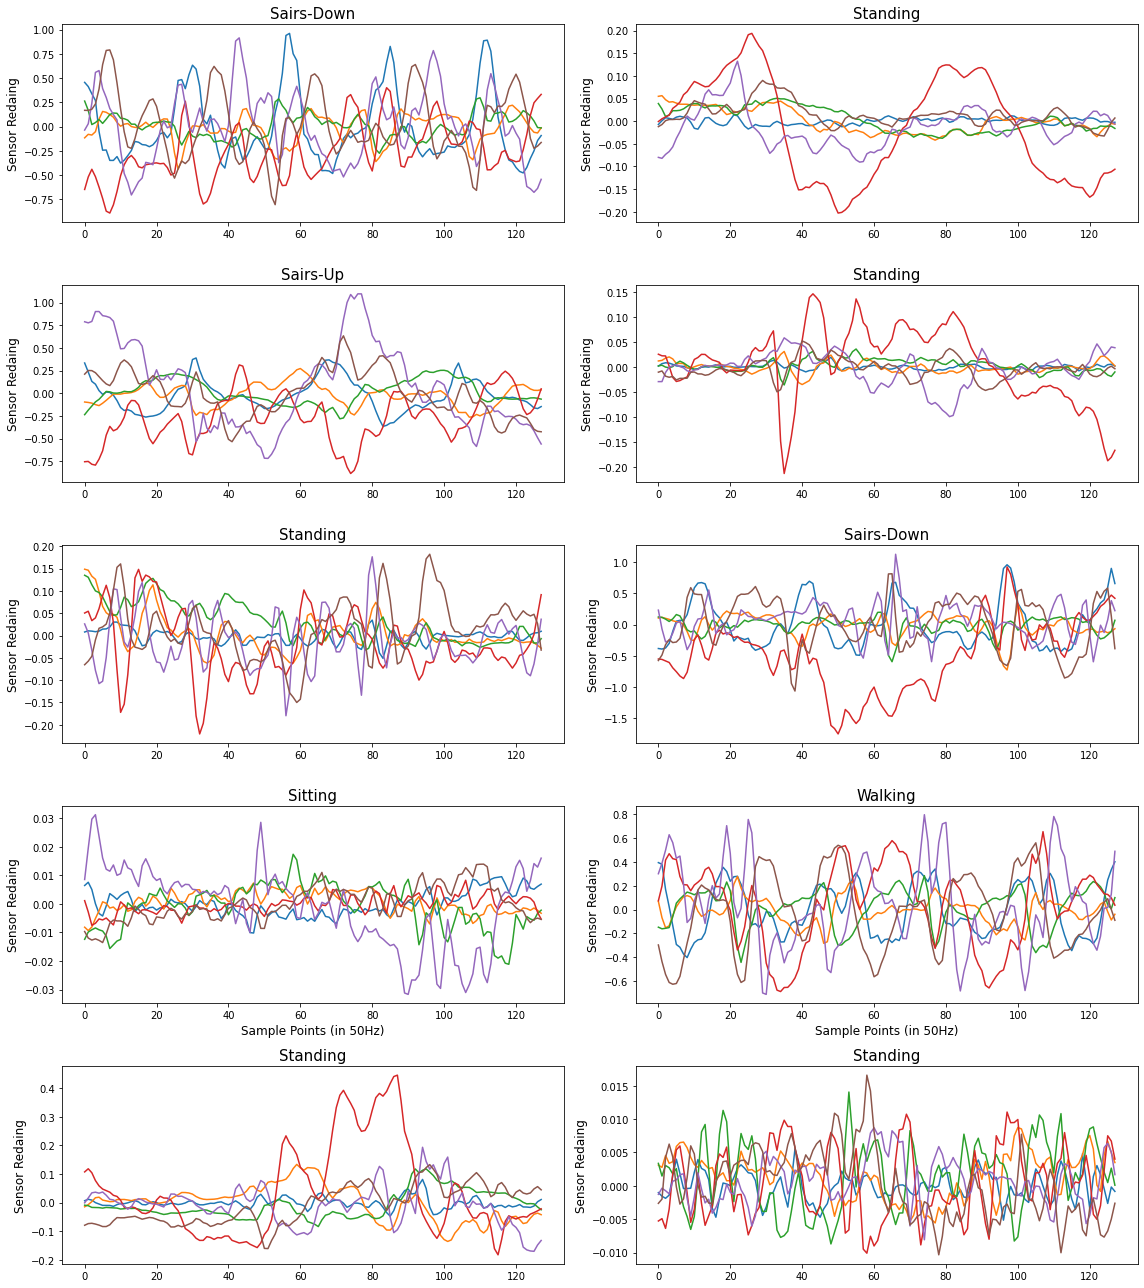

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,18))
for r in range(5):
    for c in range(2):        
        ind = np.random.choice(len(X_train))
        ax[r,c].plot(X_train[ind])
        ax[r,c].set_title(data_class_names[Y_train[ind]], size=15)
        if r == 3:
            ax[r,c].set_xlabel("Sample Points (in 50Hz)", size=12)
        ax[r,c].set_ylabel("Sensor Redaing", size=12)
fig.tight_layout()

### The Original Model

First, we build and train on of the sate-of-the-art models for activity recogniton. We call this tehe original model which is trained on the dataset on with a fixed sampling rate 50Hz and both sensors: accelerometer and gyroscope.

In [5]:
def Ordonez2016DeepOriginal(inp_shape, out_shape):   
    """
    @article{ordonez2016deep,
        title={Deep convolutional and {LSTM} recurrent neural networks for multimodal wearable activity recognition},
        author={Ord{\'o}{\~n}ez, Francisco and Roggen, Daniel},
        journal={Sensors},
        volume={16},
        number={1},
        pages={115},
        year={2016},
        publisher={Multidisciplinary Digital Publishing Institute}
    }
    """   
    nb_filters = 64 
    drp_out_dns = .5 
    nb_dense = 128 
    
    inp = Input(inp_shape)

    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(inp)    
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)    
    x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x)
    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    act = LSTM(nb_dense, activation='tanh', name="lstm_2")(act)        
    act = Dropout(drp_out_dns, name= "dot_2")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)
    
    model = keras.models.Model(inputs=inp, outputs=out_act)
    return model

In [6]:
X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)

w = X_train.shape[1]
h = X_train.shape[2]
org_model = Ordonez2016DeepOriginal((w, h, 1), len(np.unique(Y_train)))
org_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 6, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 6, 64)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 6, 64)        20544     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 6, 64)        20544     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 6, 64)        20544     
_________________________________________________________________
reshape (Reshape)            (None, 112, 384)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112, 128)         

In [7]:
def standard_training(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size)
        epoch_loss_avg = tf.keras.metrics.Mean()           
        for i in range(n_iterations_per_epoch):                
            with tf.GradientTape() as tape:
                X, Y = next(train_dataset)
                sample_weight = [data_class_weights[y] for y in Y.numpy()]                        
                logits = model(X)               
                loss_value = loss_fn(Y, logits, sample_weight)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))                        
            epoch_loss_avg.update_state(loss_value)

        ## Validation
        val_accuracy = tf.keras.metrics.Accuracy()
        logits = model(X_val, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y_val)
        current_val_acc = val_accuracy.result()
        
        if current_val_acc > best_val_accuracy:
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)
        if epoch%10 == 0:
            print ("Epoch {} -- Training Loss = {:.4f} -- Validation Accuracy {:.4f}".format(
                epoch,
                epoch_loss_avg.result(),
                current_val_acc))
        
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {:.4f}".format(best_val_accuracy))
    print("Training Finished! \n------------------\n")
    return model

In [8]:
org_model = standard_training(org_model, 
                  X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                  X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                  data_class_weights,
                  batch_size=128, num_epochs=500,
                  save_dir = "saved_models/standard/Ordonez2016DeepOriginal")

## Testing
test_accuracy = tf.keras.metrics.Accuracy()
logits = org_model(X_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, Y_test)
print("Test Accuracy {:.4f}".format(test_accuracy.result()))

Epoch 0 -- Training Loss = 1.1787 -- Validation Accuracy 0.4259
Epoch 10 -- Training Loss = 0.5356 -- Validation Accuracy 0.6449
Epoch 20 -- Training Loss = 0.4482 -- Validation Accuracy 0.7864
Epoch 30 -- Training Loss = 0.1222 -- Validation Accuracy 0.9592
Epoch 40 -- Training Loss = 0.0492 -- Validation Accuracy 0.9605
Epoch 50 -- Training Loss = 0.0213 -- Validation Accuracy 0.9701
Epoch 60 -- Training Loss = 0.0069 -- Validation Accuracy 0.9755
Epoch 70 -- Training Loss = 0.0111 -- Validation Accuracy 0.9755
Epoch 80 -- Training Loss = 0.0002 -- Validation Accuracy 0.9741
Epoch 90 -- Training Loss = 0.0001 -- Validation Accuracy 0.9741
Epoch 100 -- Training Loss = 0.0001 -- Validation Accuracy 0.9741
Epoch 110 -- Training Loss = 0.0000 -- Validation Accuracy 0.9741
Epoch 120 -- Training Loss = 0.0000 -- Validation Accuracy 0.9755
Epoch 130 -- Training Loss = 0.0000 -- Validation Accuracy 0.9755
Epoch 140 -- Training Loss = 0.0000 -- Validation Accuracy 0.9741
Epoch 150 -- Training

## Dimension-Adaptive Pooling  (DAP) Layer

DAP layer provides a fixed-sized output and preserves temporal correlation among consecutive data samples. This is important as RNNs are more efficient in processing temporal data than FNNs. Moreover, DAP can handle situations when one or more sensors may be unavailable at inference time. The flexibility of DAP not only makes DNNs adaptive to changes in the dimension of data, but allows us to efficiently train the DNN such that it provides reliable performance across several combinations of data dimensions.

![alt text](https://raw.githubusercontent.com/mmalekzadeh/dana/master/dana.jpg)


In [9]:
from tensorflow.keras import layers
from tensorflow.python.framework import tensor_shape
# Parts of the code is taken from this repo: https://github.com/yhenon/keras-spp          
class DimensionAdaptivePooling(layers.Layer):
    """ Dimension Adaptive Pooling layer for 2D inputs.
    # Arguments
        pool_list: a tuple (W,H)
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each tuple in the list is the number of regions in that pool. For example [(8,6),(4,3)] would be 2
            regions with 1, 8x6 and 4x3 max pools, so 48+12 outputs per feature map.
        forRNN: binary
            Determines wheterh the layer after this is a recurrent layer (LSTM) or not (it is Dense)
        operation: string
            Either `max` or `avg`.
    # Input shape
        4D tensor with shape: `(samples, w, h, M)` .
    # Output shape
        2D or 3D tensor with shape: `(samples,  W*H*M)` or `(samples,  W, H*M)`.
    """
    def __init__(self, pooling_parameters, forRNN=False, operation="max", name=None, **kwargs):
        super(DimensionAdaptivePooling, self).__init__(name=name, **kwargs)
        self.pool_list = np.array(pooling_parameters)
        self.forRNN = forRNN
        self.W = self.pool_list[0]
        self.H = self.pool_list[1]
        self.num_outputs_per_feature_map =  self.W * self.H
        if operation == "max":
            self.operation = tf.math.reduce_max
        elif operation == "avg":
            self.operation = tf.math.reduce_mean
       
    def build(self, input_shape):        
        self.M = input_shape[3]      

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()        
        if self.forRNN:
            return tensor_shape.TensorShape([input_shape[0], self.W, self.H * self.M])
        else:
            return tensor_shape.TensorShape([input_shape[0], self.W * self.H * self.M])

    def get_config(self):
        config = {'dap pooling parameters': self.pool_list, 'forRNN': self.forRNN}
        base_config = super(DimensionAdaptivePooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))    


class DimensionAdaptivePoolingForSensors(DimensionAdaptivePooling):
    def __init__(self, pooling_parameters, forRNN=False, operation="max", name=None, **kwargs):
        super(DimensionAdaptivePoolingForSensors, self).__init__(pooling_parameters=pooling_parameters, 
                                                                forRNN=forRNN, 
                                                                operation=operation,
                                                                name=name, **kwargs)      
    def call(self, xp, mask=None):
        xp_dtype = xp.dtype                
        input_shape = tf.shape(xp)
        wp = input_shape[1] ## This is the number of sample points in each time-window (w')
        hp = input_shape[2] ## This is the number of sensor channels (h')
        
        xpp = tf.identity(xp)
        try:
            A = tf.cast(tf.math.maximum(tf.math.ceil((self.H-hp)/3),0), dtype=xp_dtype)
            for ia in range(tf.cast(A, tf.int32)):
                xpp = tf.concat([xpp, xp],2)                                                                         
            xpp = xpp[:, :wp, :tf.math.maximum(hp,self.H), :]
        except:
            A = tf.Variable(0,dtype=xp_dtype)        
        p_w = tf.cast(wp / self.W, dtype=xp_dtype)
        p_h = tf.cast(hp / self.H, dtype=xp_dtype)
        Zp = []
        for iw in range(self.W):                
            for ih in range(self.H):
                r1 = tf.cast(tf.math.round(iw * p_w), tf.int32)
                r2 = tf.cast(tf.math.round((iw+1) * p_w), tf.int32)
                if A == 0:
                    c1 = tf.cast(tf.math.round(ih *p_h), tf.int32)
                    c2 = tf.cast(tf.math.round((ih+1)*p_h), tf.int32)
                else:
                    c1 = tf.cast(tf.math.round(ih * tf.math.floor((A+1)*p_h)), tf.int32)
                    c2 = tf.cast(tf.math.round((ih+1) * tf.math.floor((A+1)*p_h)), tf.int32)
                try:                                               
                    Zp.append(self.operation(xpp[:, r1:r2, c1:c2, :], axis=(1, 2)))
                except:
                    Zp = []
        Zp = tf.concat(Zp, axis=-1)
        if self.forRNN:
            Zp = tf.reshape(Zp,(input_shape[0], self.W, self.H * self.M))
        else:
            Zp = tf.reshape(Zp,(input_shape[0], self.W * self.H * self.M))
        return Zp

In [10]:
def Ordonez2016DeepWithDAP(inp_shape, out_shape, pool_list=(4,6)):      
    nb_filters = 64 
    drp_out_dns = .5 
    nb_dense = 128 

    inp = Input(inp_shape)

    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='same', activation='relu')(inp)    
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='same', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='same', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='same', activation='relu')(x)    
    #### DAP Layer    
    x = DimensionAdaptivePoolingForSensors(pool_list, operation="max", name ="DAP", forRNN=True)(x)    

    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    act = LSTM(nb_dense, activation='tanh', name="lstm_2")(act)        
    act = Dropout(drp_out_dns, name= "dot_2")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)

    model = keras.models.Model(inputs=inp, outputs=out_act)
    return model

dana_model = Ordonez2016DeepWithDAP((None, None, 1), len(np.unique(Y_train)))
dana_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
DAP (DimensionAdaptivePoolin (None, 4, 384)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)           

## Dimension-Adaptive Training (DAT)

To enable DNNs that use DAP to generalize at inference time over the set of feasible dimensions, we propose a dimension-adaptive training~(DAT) procedure, which incorporates dimension randomization and optimization with accumulated gradients. In each forward pass, DAT re-samples a batch of time widows to a new rate and may also cope with removed streams  from some sensors. Then, gradients from several batches are accumulated before updating the parameters. Combining DAP and DAT, we show how to transform an existing DNN into an adaptive architecture, while keeping the same size and accuracy, and improving the inference time. Beside allowing adaptive sampling rate and sensor selection in a unified solution, DANA also enables power-limited devices to take advantage of convolutional layers capability in reducing the performed computations according to the dimensions of the sampled data.

![alt text](https://raw.githubusercontent.com/mmalekzadeh/dana/master/dat.jpg)


In [11]:
def dimension_adaptive_training(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None,
                      W_combinations=None, H_combinations=None,
                      n_batch_per_train_setp=1):
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size*n_batch_per_train_setp)
        epoch_loss_avg = tf.keras.metrics.Mean()           

        for i in range(n_iterations_per_epoch):
            rnd_order_H = np.random.permutation(len(H_combinations))
            rnd_order_W = np.random.permutation(len(W_combinations))
            n_samples = 0.
            with tf.GradientTape() as tape:
                accum_loss = tf.Variable(0.)
                for j in range(n_batch_per_train_setp):
                    try:
                        X, Y = next(train_dataset)
                    except:
                        break
                    X = X.numpy()
                    sample_weight = [data_class_weights[y] for y in Y.numpy()]
                    
                    ### Dimension Randomization 
                    ####### Random Sensor Selection
                    rnd_H = H_combinations[rnd_order_H[j%len(rnd_order_H)]]                    
                    X = X[:,:,rnd_H,:] 
                    ####### Random Sampling Rate Selection  
                    rnd_W = W_combinations[rnd_order_W[j%len(rnd_order_W)]]
                    X = tf.image.resize(X, (rnd_W, len(rnd_H)))    

                    logits =  model(X)               
                    accum_loss = accum_loss + loss_fn(Y, logits, sample_weight)
                    n_samples = n_samples + 1.
            gradients = tape.gradient(accum_loss, model.trainable_weights)
            gradients = [g*(1./n_samples) for g in gradients]
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            epoch_loss_avg.update_state(accum_loss*(1./n_samples))

        ## Validation
        accuracy_record = np.zeros((len(W_combinations),len(H_combinations)))
        for w, W_comb in enumerate(W_combinations):
            for h, H_comb in enumerate(H_combinations):                    
                val_accuracy = tf.keras.metrics.Accuracy()

                X = X_val.copy()                                    
                X = X[:,:,H_comb,:]
                X = tf.image.resize(X, (W_comb, len(H_comb)))

                logits = model(X, training=False)
                prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
                val_accuracy(prediction, Y_val)
                accuracy_record[w,h] = val_accuracy.result()
        
        current_val_acc = accuracy_record
        if np.mean(current_val_acc) > np.mean(best_val_accuracy):
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)
        if epoch%5 == 0:
            print ("Epoch {} -- Training Loss = {:.4f} -- Validation Mean Accuracy {:.4f}".format(
                epoch,
                epoch_loss_avg.result(),
                np.mean(current_val_acc)))
        
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {}".format(best_val_accuracy.round(4)))
    print("Training Finished! \n------------------\n")
    return model


### These are a subset of feasible situations in both dimensions
W_combinations = list(np.arange(16,129,16))
H_combinations = [[0,1,2], [3,4,5], [0,1,2,3,4,5], [3,4,5,0,1,2]]
n_batch_per_train_setp = 5 ## This is B

In [12]:
dana_model = dimension_adaptive_training(dana_model, 
                  X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                  X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                  data_class_weights,
                  batch_size=128, num_epochs=500,
                  save_dir = "saved_models/dana/Ordonez2016DeepWithDAP",
                  W_combinations = W_combinations,
                  H_combinations = H_combinations,
                  n_batch_per_train_setp=n_batch_per_train_setp
                  )

Epoch 0 -- Training Loss = 1.6663 -- Validation Mean Accuracy 0.2889
Epoch 5 -- Training Loss = 0.9533 -- Validation Mean Accuracy 0.5063
Epoch 10 -- Training Loss = 0.8056 -- Validation Mean Accuracy 0.5722
Epoch 15 -- Training Loss = 0.7737 -- Validation Mean Accuracy 0.5814
Epoch 20 -- Training Loss = 0.6879 -- Validation Mean Accuracy 0.6402
Epoch 25 -- Training Loss = 0.6310 -- Validation Mean Accuracy 0.6662
Epoch 30 -- Training Loss = 0.5865 -- Validation Mean Accuracy 0.7230
Epoch 35 -- Training Loss = 0.5458 -- Validation Mean Accuracy 0.7363
Epoch 40 -- Training Loss = 0.5146 -- Validation Mean Accuracy 0.7523
Epoch 45 -- Training Loss = 0.4856 -- Validation Mean Accuracy 0.7594
Epoch 50 -- Training Loss = 0.4982 -- Validation Mean Accuracy 0.7703
Epoch 55 -- Training Loss = 0.4727 -- Validation Mean Accuracy 0.7715
Epoch 60 -- Training Loss = 0.4352 -- Validation Mean Accuracy 0.7963
Epoch 65 -- Training Loss = 0.4291 -- Validation Mean Accuracy 0.7978
Epoch 70 -- Training L

In [13]:
dana_model.load_weights("saved_models/dana/Ordonez2016DeepWithDAP")
accuracy_record = np.zeros((len(W_combinations),len(H_combinations)))
for w, W_comb in enumerate(W_combinations):
    for h, H_comb in enumerate(H_combinations):                    
        test_accuracy = tf.keras.metrics.Accuracy()

        X = X_test.copy()                                    
        X = X[:,:,H_comb,:]
        X = tf.image.resize(X, (W_comb, len(H_comb)))

        logits = dana_model(X, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        test_accuracy(prediction, Y_test)
        accuracy_record[w,h] = test_accuracy.result()

print("Test  Mean Accuracy {:.4f}".format(np.mean(accuracy_record)))
print("Test Accuracies {}".format((accuracy_record.round(4))))

Test  Mean Accuracy 0.8707
Test Accuracies [[0.7536 0.757  0.9006 0.8914]
 [0.8215 0.7923 0.9298 0.9243]
 [0.8341 0.8066 0.9332 0.9308]
 [0.8456 0.8093 0.9382 0.9352]
 [0.8449 0.8076 0.9382 0.9328]
 [0.8504 0.8147 0.9345 0.9308]
 [0.8463 0.8113 0.9304 0.9291]
 [0.8426 0.7967 0.9264 0.9226]]


## Comparing DANA with the Original model

The original model only works on input data that have fixed dimensions. So, we cannot test it on the sampling rate lower than 50Hz, unless we perform upsampling.

More importantly, when it misses a sensor, we have to imput the data of the missed sensor with either zeros or with the currently available data of another sensor.

In [14]:
def test_model(model, X, Y):
    test_accuracy = tf.keras.metrics.Accuracy()
    logits = model(X, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, Y)
    return test_accuracy.result()

org_model.load_weights("saved_models/standard/Ordonez2016DeepOriginal")
org_both = test_model(org_model, X_test, Y_test)
org_accl = test_model(org_model, np.concatenate((X_test[:,:,:3,:], np.zeros_like(X_test[:,:,:3,:])),axis=2), Y_test)
org_gyro = test_model(org_model, np.concatenate((X_test[:,:,3:,:], np.zeros_like(X_test[:,:,3:,:])),axis=2), Y_test)
print("Original Model Test Accuracy \n Both: {:.4f} \n Only Accl: {:.4f} \n Only Gyro: {:.4f}".format(org_both, org_accl, org_gyro))

Original Model Test Accuracy 
 Both: 0.9365 
 Only Accl: 0.5226 
 Only Gyro: 0.3010


In [15]:
def test_model(model, X, Y):
    test_accuracy = tf.keras.metrics.Accuracy()
    logits = model(X, training=False)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, Y)
    return test_accuracy.result()

org_model.load_weights("saved_models/standard/Ordonez2016DeepOriginal")
org_both = test_model(org_model, X_test, Y_test)
org_accl = test_model(org_model, np.concatenate((X_test[:,:,:3,:],X_test[:,:,:3,:]),axis=2), Y_test)
org_gyro = test_model(org_model, np.concatenate((X_test[:,:,3:,:],X_test[:,:,3:,:]),axis=2), Y_test)
print("Original Model Test Accuracy \n Both: {:.4f} \n Only Accl: {:.4f} \n Only Gyro: {:.4f}".format(org_both, org_accl, org_gyro))

Original Model Test Accuracy 
 Both: 0.9365 
 Only Accl: 0.6454 
 Only Gyro: 0.4041


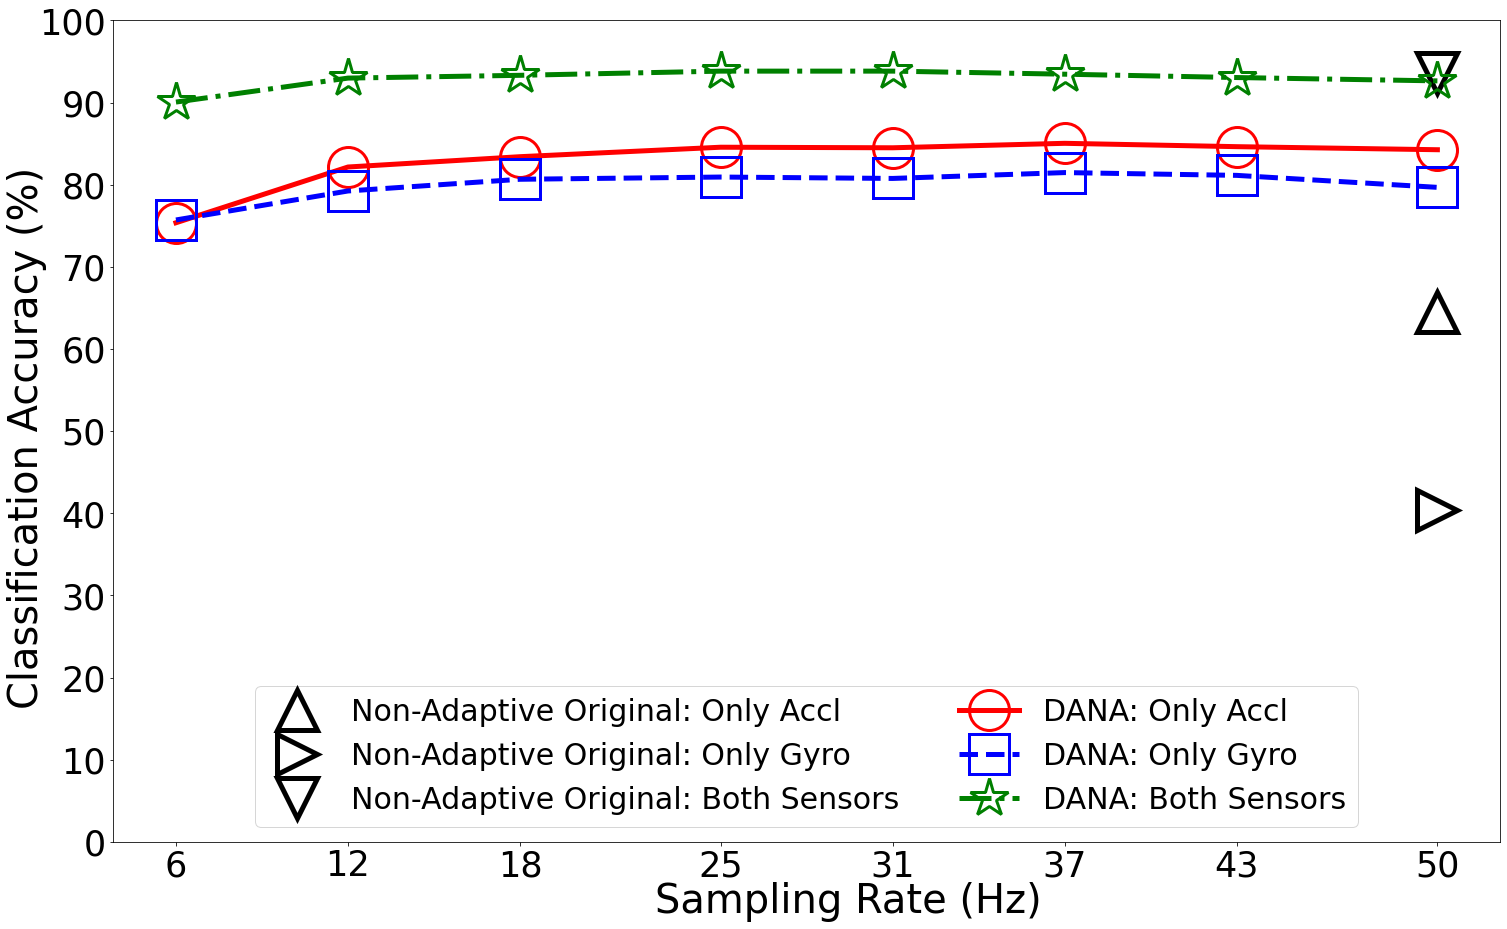

In [16]:
labels = ["DANA: Only Accl", "DANA: Only Gyro",
         "DANA: Both Sensors"]
markers = ["-or","--sb","-.*g"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
fig.tight_layout()


plt.plot(50,org_accl*100, "^k", label="Non-Adaptive Original: Only Accl", markersize= 40, linewidth=5,
          markerfacecolor="None",  markeredgewidth=5)
plt.plot(50,org_gyro*100, ">k", label="Non-Adaptive Original: Only Gyro", markersize= 40, linewidth=5,
          markerfacecolor="None",  markeredgewidth=5)
plt.plot(50,org_both*100, "vk", label="Non-Adaptive Original: Both Sensors", markersize= 40, linewidth=5,
          markerfacecolor="None",  markeredgewidth=5)

for i in range(len(H_combinations)-1):
    y_data = accuracy_record[:,i]*100
    x_data = np.floor(np.array(W_combinations)/(2.56))
    
    ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
            markerfacecolor="None",  markeredgewidth=3)    


ax.set_xticks(x_data)
plt.setp(ax.get_xticklabels(), fontsize=35)    
ax.set_yticks(np.arange(0,101,10))
plt.setp(ax.get_yticklabels(), fontsize=35)

fig.text(0.4, -0.05, "Sampling Rate (Hz)", size = 40)
fig.text(-0.05, 0.5, "Classification Accuracy (%)", va='center', rotation='vertical', size = 40)
ax.legend(loc= "lower center",prop={'size': 30}, ncol=2)
plt.show()

#### I hope you enjoyed it!. You can find more info. and examples in this link: https://github.com/mmalekzadeh/dana